# Pylops - Sparse solvers with cupy

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import numpy as np
import cupy as cp
import scipy as sp
import cusignal
import matplotlib.pyplot as plt

from scipy.signal import convolve, filtfilt
from scipy.sparse.linalg import inv, lsqr
from scipy.sparse import rand
from skimage.data import shepp_logan_phantom

from pylops.utils import dottest
from pylops.utils.seismicevents import *
from pylops.utils.wavelets import *
from pylops.utils.tapers import *
from pylops import LinearOperator
from pylops.basicoperators import *
from pylops.signalprocessing import *
from pylops.optimization.leastsquares import *
from pylops.optimization.sparsity import *

cp.random.seed(5)
np.random.seed(5)

## MP, OMP, STA , FISTA

In [2]:
N, M = 15, 20
A = np.random.randn(N, M)
A = A / np.linalg.norm(A, axis=0)
A = cp.array(A)
Aop = MatrixMult(A)

x = cp.random.rand(M)
x[x < 0.9] = 0
y = Aop*x

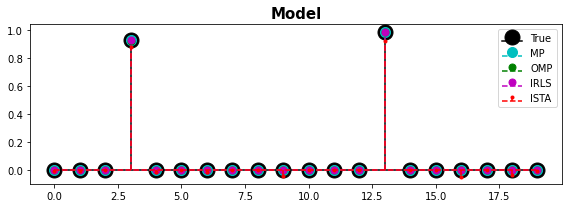

In [3]:
# MP/OMP
eps = 1e-2
maxit = 500
x_mp = omp(Aop, y, niter_outer=maxit, niter_inner=0, sigma=1e-4)[0]
x_omp = omp(Aop, y, niter_outer=maxit, sigma=1e-4)[0]

# IRLS
x_irls = irls(Aop, y, nouter=50, epsI=1e-5, kind='model', **dict(niter=10))[0]

# ISTA
x_ista = ista(Aop, y, niter=maxit, eps=eps, alpha=2.569474e-01, tol=1e-3, show=False)[0]

fig, ax = plt.subplots(1, 1, figsize=(8, 3))
m, s, b = ax.stem(cp.asnumpy(x), linefmt='k', basefmt='k',
                  markerfmt='ko', label='True')
plt.setp(m, markersize = 15)
m, s, b = ax.stem(cp.asnumpy(x_mp), linefmt='--c', basefmt='--c',
        markerfmt='co', label='MP')
plt.setp(m, markersize = 10)
m, s, b = ax.stem(cp.asnumpy(x_omp), linefmt='--g', basefmt='--g',
        markerfmt='go', label='OMP')
plt.setp(m, markersize = 7)
m, s, b = ax.stem(cp.asnumpy(x_irls), linefmt='--m', basefmt='--m',
                  markerfmt='mo', label='IRLS')
plt.setp(m, markersize=7)
m, s, b = ax.stem(cp.asnumpy(x_ista), linefmt='--r', basefmt='--r',
                  markerfmt='ro', label='ISTA')
plt.setp(m, markersize = 3)
ax.set_title('Model', size=15, fontweight='bold')
ax.legend()
plt.tight_layout()

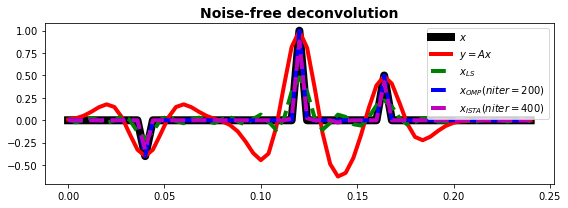

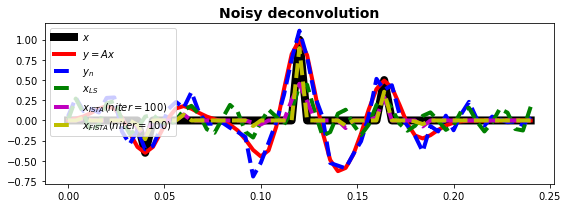

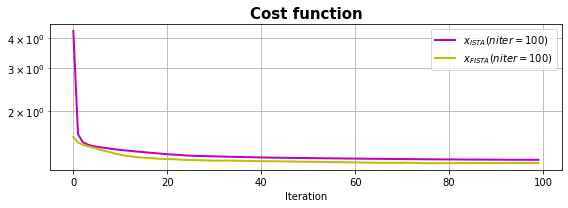

In [4]:
# numpy
nt = 61
dt = 0.004
t = np.arange(nt)*dt
x = np.zeros(nt, dtype='float32')
x[10] = -.4
x[int(nt/2)] = 1
x[nt-20] = 0.5

h, th, hcenter = ricker(t[:101], f0=20)

Cop = Convolve1D(nt, h=h.astype('float32'), offset=hcenter, dtype='float32')
y = Cop*x
yn = y + np.random.normal(0, 0.1, y.shape).astype('float32')

# noise free
xls = Cop / y

xomp, nitero, costo = omp(Cop, y, niter_outer=200, sigma=1e-8)

xista, niteri, costi = ista(Cop, y, niter=400, eps=5e-1, tol=1e-8)

fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.plot(t, x, 'k', lw=8, label=r'$x$')
ax.plot(t, y, 'r', lw=4, label=r'$y=Ax$')
ax.plot(t, xls, '--g', lw=4, label=r'$x_{LS}$')
ax.plot(t, xomp, '--b', lw=4, label=r'$x_{OMP} (niter=%d)$' % nitero)
ax.plot(t, xista, '--m', lw=4, label=r'$x_{ISTA} (niter=%d)$' % niteri)

ax.set_title('Noise-free deconvolution', fontsize=14, fontweight='bold')
ax.legend()
plt.tight_layout()

# noisy
xls = regularized_inversion(Cop, yn, None,
                            **dict(damp=1e-1,
                                   atol=1e-3,
                                   iter_lim=100,
                                   show=0))[0]

xista, niteri, costi = ista(Cop, yn, niter=100, eps=5e-1, tol=1e-5)

xfista, niterf, costf = fista(Cop, yn, niter=100, eps=5e-1, tol=1e-5)

fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.plot(t, x, 'k', lw=8, label=r'$x$')
ax.plot(t, y, 'r', lw=4, label=r'$y=Ax$')
ax.plot(t, yn, '--b', lw=4, label=r'$y_n$')
ax.plot(t, xls, '--g', lw=4, label=r'$x_{LS}$')
ax.plot(t, xista, '--m', lw=4, label=r'$x_{ISTA} (niter=%d)$' % niteri)
ax.plot(t, xfista, '--y', lw=4, label=r'$x_{FISTA} (niter=%d)$' % niterf)
ax.set_title('Noisy deconvolution', fontsize=14, fontweight='bold')
ax.legend()
plt.tight_layout()

fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.semilogy(costi, 'm', lw=2, label=r'$x_{ISTA} (niter=%d)$' % niteri)
ax.semilogy(costf, 'y', lw=2, label=r'$x_{FISTA} (niter=%d)$' % niterf)
ax.set_title('Cost function', size=15, fontweight='bold')
ax.set_xlabel('Iteration')
ax.legend()
ax.grid(True, which='both')
plt.tight_layout()

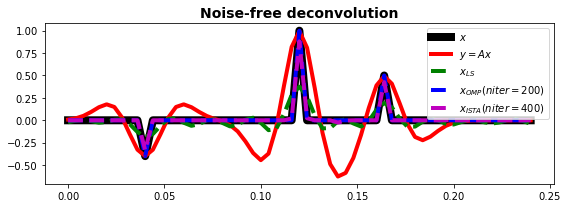

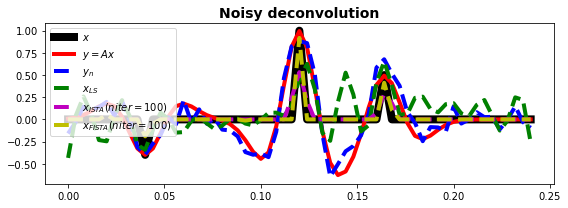

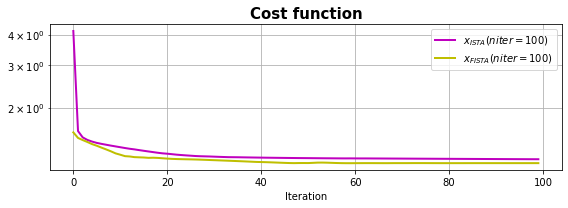

In [5]:
# cupy
x = cp.array(x)

Cop = Convolve1D(nt, h=cp.array(h).astype('float32'), offset=hcenter, dtype='float32')
y = Cop*x
yn = y + cp.random.normal(0, 0.1, y.shape).astype('float32')

# noise free
xls = Cop / y

xomp, nitero, costo = omp(Cop, y, niter_outer=200, sigma=1e-8)

xista, niteri, costi = ista(Cop, y, niter=400, alpha=3.842706e-2, eps=5e-1, tol=1e-8)

fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.plot(cp.asnumpy(t), cp.asnumpy(x), 'k', lw=8, label=r'$x$')
ax.plot(cp.asnumpy(t), cp.asnumpy(y), 'r', lw=4, label=r'$y=Ax$')
ax.plot(cp.asnumpy(t), cp.asnumpy(xls), '--g', lw=4, label=r'$x_{LS}$')
ax.plot(cp.asnumpy(t), cp.asnumpy(xomp), '--b', lw=4, label=r'$x_{OMP} (niter=%d)$' % nitero)
ax.plot(cp.asnumpy(t), cp.asnumpy(xista), '--m', lw=4, label=r'$x_{ISTA} (niter=%d)$' % niteri)

ax.set_title('Noise-free deconvolution', fontsize=14, fontweight='bold')
ax.legend()
plt.tight_layout()

# noisy
xls = regularized_inversion(Cop,  yn, None,
                            **dict(damp=1e-1,
                                   niter=100,
                                   show=0))[0]

xista, niteri, costi = ista(Cop, yn, niter=100,alpha=3.842706e-2, eps=5e-1, tol=1e-5)

xfista, niterf, costf = fista(Cop, yn, niter=100, alpha=3.842706e-2, eps=5e-1, tol=1e-5)

fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.plot(cp.asnumpy(t), cp.asnumpy(x), 'k', lw=8, label=r'$x$')
ax.plot(cp.asnumpy(t), cp.asnumpy(y), 'r', lw=4, label=r'$y=Ax$')
ax.plot(cp.asnumpy(t), cp.asnumpy(yn), '--b', lw=4, label=r'$y_n$')
ax.plot(cp.asnumpy(t), cp.asnumpy(xls), '--g', lw=4, label=r'$x_{LS}$')
ax.plot(cp.asnumpy(t), cp.asnumpy(xista), '--m', lw=4, label=r'$x_{ISTA} (niter=%d)$' % niteri)
ax.plot(cp.asnumpy(t), cp.asnumpy(xfista), '--y', lw=4, label=r'$x_{FISTA} (niter=%d)$' % niterf)
ax.set_title('Noisy deconvolution', fontsize=14, fontweight='bold')
ax.legend()
plt.tight_layout()

fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.semilogy(costi, 'm', lw=2, label=r'$x_{ISTA} (niter=%d)$' % niteri)
ax.semilogy(costf, 'y', lw=2, label=r'$x_{FISTA} (niter=%d)$' % niterf)
ax.set_title('Cost function', size=15, fontweight='bold')
ax.set_xlabel('Iteration')
ax.legend()
ax.grid(True, which='both')
plt.tight_layout()

## Split-Bregman

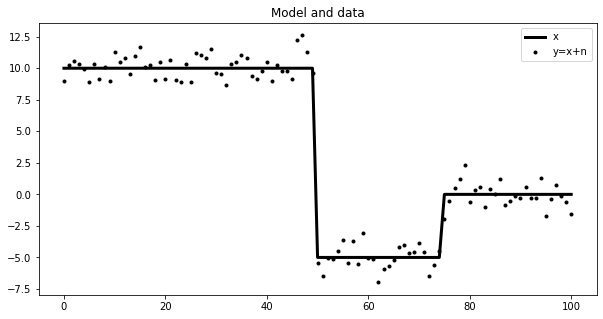

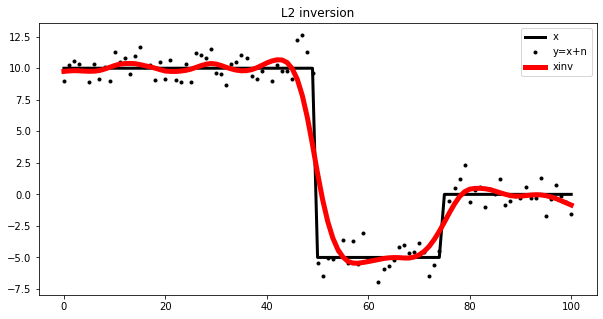

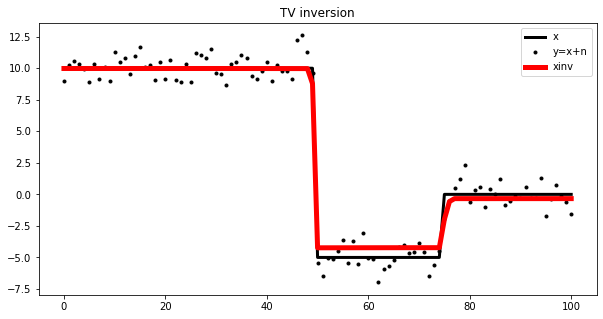

In [6]:
np.random.seed(1)

nx = 101
x = cp.zeros(nx)
x[:nx//2] = 10
x[nx//2:3*nx//4] = -5

Iop = Identity(nx)

n = cp.random.normal(0, 1, nx)
y = Iop * (x + n)

plt.figure(figsize=(10, 5))
plt.plot(cp.asnumpy(x), 'k', lw=3, label='x')
plt.plot(cp.asnumpy(y), '.k', label='y=x+n')
plt.legend()
plt.title('Model and data')

D2op = SecondDerivative(nx, edge=True)
lamda = 1e2

xinv = regularized_inversion(Iop, y, [D2op], epsRs=[np.sqrt(lamda/2)], **dict(niter=30))[0]

plt.figure(figsize=(10, 5))
plt.plot(cp.asnumpy(x), 'k', lw=3, label='x')
plt.plot(cp.asnumpy(y), '.k', label='y=x+n')
plt.plot(cp.asnumpy(xinv), 'r', lw=5, label='xinv')
plt.legend()
plt.title('L2 inversion')

Dop = FirstDerivative(nx, edge=True, kind='backward')
mu = 0.01
lamda = 0.3
niter_out = 50
niter_in = 3

xinv, niter = \
    splitbregman(Iop,  y, [Dop], niter_outer=niter_out,
                 niter_inner=niter_in, mu=mu, epsRL1s=[lamda],
                 tol=1e-4, tau=1.,
                 **dict(niter=30, damp=1e-10))[:2]

plt.figure(figsize=(10, 5))
plt.plot(cp.asnumpy(x), 'k', lw=3, label='x')
plt.plot(cp.asnumpy(y), '.k', label='y=x+n')
plt.plot(cp.asnumpy(xinv), 'r', lw=5, label='xinv')
plt.legend()
plt.title('TV inversion');

SplitBregman
-----------------------------------------------------------------
The Operator Op has 24000 rows and 40000 cols
niter_outer =  20     niter_inner =  10   tol = 1.00e-04
mu = 1.50e+00         epsL1 = [0.1, 0.1]	  epsL2 = []
-----------------------------------------------------------------
    Itn          x[0]            r2norm           r12norm
     1    -2.84e-02-3.75e-02j    2.754e-01        1.992e+03
     2    3.18e-03-2.22e-02j    2.650e-01        1.441e+03
     3    3.41e-02-1.10e-02j    2.413e-01        1.382e+03
     4    6.01e-02-5.74e-03j    2.165e-01        1.347e+03
     5    7.52e-02-4.20e-03j    1.970e-01        1.326e+03
     6    7.99e-02-3.47e-03j    1.816e-01        1.324e+03
     7    7.54e-02-2.45e-03j    1.724e-01        1.329e+03
     8    7.52e-02-3.18e-03j    1.647e-01        1.318e+03
     9    7.52e-02-3.24e-03j    1.597e-01        1.317e+03
    10    4.29e-02-3.12e-03j    1.512e-01        1.295e+03
    11    1.47e-02-3.08e-03j    1.449e-01        

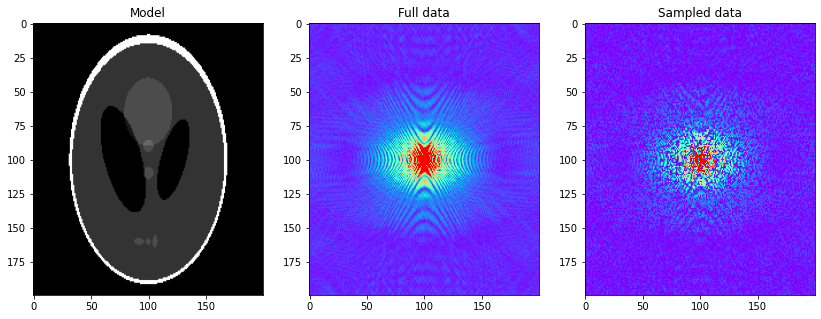

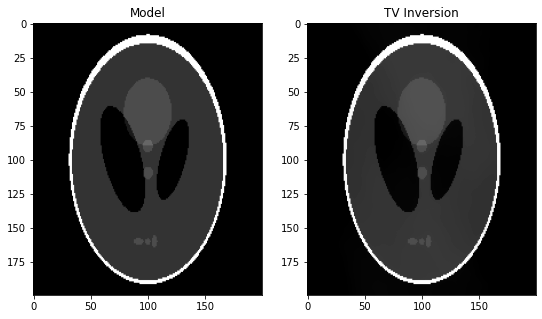

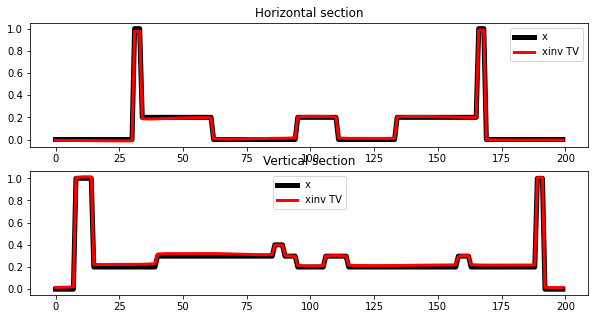

In [7]:
x = cp.array(shepp_logan_phantom()[::2, ::2])
x = x/x.max()
ny, nx = x.shape

perc_subsampling = 0.6
nxsub = int(np.round(ny*nx*perc_subsampling))
iava = np.sort(np.random.permutation(np.arange(ny*nx))[:nxsub])
Rop = Restriction(ny*nx, iava, dtype=np.complex128)
Fop = FFT2D(dims=(ny, nx))

n = cp.random.normal(0, 0., (ny, nx))
y = Rop*Fop*(x.flatten() + n.flatten())
yfft = Fop*(x.flatten() + n.flatten())
yfft = cp.fft.fftshift(yfft.reshape(ny, nx))

ymask = Rop.mask(Fop*(x.flatten()) + n.flatten())
ymask = ymask.reshape(ny, nx)
ymask.data[:] = np.fft.fftshift(ymask.data)
ymask.mask[:] = np.fft.fftshift(ymask.mask)

fig, axs = plt.subplots(1, 3, figsize=(14, 5))
axs[0].imshow(cp.asnumpy(x), vmin=0, vmax=1, cmap='gray')
axs[0].set_title('Model')
axs[0].axis('tight')
axs[1].imshow(cp.asnumpy(np.abs(yfft)), vmin=0, vmax=1, cmap='rainbow')
axs[1].set_title('Full data')
axs[1].axis('tight')
axs[2].imshow(cp.asnumpy(np.abs(ymask)), vmin=0, vmax=1, cmap='rainbow')
axs[2].set_title('Sampled data')
axs[2].axis('tight')

Dop = \
    [FirstDerivative(dims=(ny, nx), axis=0, edge=False, kind='backward', dtype=np.complex128),
     FirstDerivative(dims=(ny, nx), axis=1, edge=False, kind='backward', dtype=np.complex128)]

# TV
mu = 1.5
lamda = [0.1, 0.1]
niter = 20
niterinner = 10

xinv, niter = \
    splitbregman(Rop * Fop, y.flatten(), Dop, 
                 niter_outer=niter, niter_inner=niterinner,
                 mu=mu, epsRL1s=lamda,
                 tol=1e-4, tau=1., show=True,
                 **dict(niter=5, damp=1e-8))[:2]
xinv = cp.real(xinv.reshape(ny, nx))

fig, axs = plt.subplots(1, 2, figsize=(9, 5))
axs[0].imshow(cp.asnumpy(x), vmin=0, vmax=1, cmap='gray')
axs[0].set_title('Model')
axs[0].axis('tight')
axs[1].imshow(cp.asnumpy(xinv), vmin=0, vmax=1, cmap='gray')
axs[1].set_title('TV Inversion')
axs[1].axis('tight')

fig, axs = plt.subplots(2, 1, figsize=(10, 5))
axs[0].plot(cp.asnumpy(x[ny//2]), 'k', lw=5, label='x')
axs[0].plot(cp.asnumpy(xinv[ny//2]), 'r', lw=3, label='xinv TV')
axs[0].set_title('Horizontal section')
axs[0].legend()
axs[1].plot(cp.asnumpy(x[:, nx//2]), 'k', lw=5, label='x')
axs[1].plot(cp.asnumpy(xinv[:, nx//2]), 'r', lw=3, label='xinv TV')
axs[1].set_title('Vertical section')
axs[1].legend()